In [41]:
google_colab = False

# Google Colab用事前準備

In [42]:
# install
try:
    import binarybrain as bb
except:
    if google_colab and False:
        !pip install pybind11
        %cd /content
        !nvcc -V
        !sudo rm -fr BinaryBrain
        !rm -fr BinaryBrain
        !git clone --recursive -b ver3_develop https://github.com/ryuz/BinaryBrain.git
        %cd /content/BinaryBrain/python
        !sh copy_src.sh
        !python3 setup.py build
        !python3 setup.py develop

        import binarybrain as bb

In [43]:
# mount
if google_colab:
  from google.colab import drive 
  drive.mount('/content/drive')
  %cd /content/drive/My Drive/git-work/BinaryBrain_ver3_develop/tests/python

In [44]:
device = 0

import binarybrain as bb

import importlib
importlib.reload(bb)
bb.omp_set_num_threads(4)
bb.set_device(device)
prop = bb.get_device_properties(device)
print(prop)


name                     : GeForce GTX 1660 SUPER
totalGlobalMem           : 6442450944
sharedMemPerBlock        : 49152
regsPerBlock             : 65536
warpSize                 : 32
memPitch                 : 2147483647
maxThreadsPerBlock       : 1024
maxThreadsDim[0]         : 1024
maxThreadsDim[1]         : 1024
maxThreadsDim[2]         : 64
maxGridSize[0]           : 2147483647
maxGridSize[1]           : 65535
maxGridSize[2]           : 65535
clockRate                : 1800000
totalConstMem            : 65536
major                    : 7
minor                    : 5
textureAlignment         : 512
deviceOverlap            : 1
multiProcessorCount      : 22
kernelExecTimeoutEnabled : 1
integrated               : 0
canMapHostMemory         : 1
computeMode              : 0




# メインコード

In [45]:
import binarybrain as bb
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import OrderedDict

In [46]:
# load MNIST data
td = bb.load_mnist()

# ネットワーク構築

In [47]:
epoch_size = 4
modulation_size = 16
mini_batch_size = 32

data_path = 'MnistDistillationTest3'
os.makedirs(data_path, exist_ok=True)
network_name = 'mnist-distillation-test3'

## 蒸留用クラス

In [48]:
def lut_sort(lut, order):
    group_size  = order.shape[0]
    output_size = lut.get_output_node_size()
    input_size  = lut.get_input_node_size()
    input_unit  = input_size // group_size
    output_unit = output_size // group_size
    for g in range(group_size):
        for o in range(output_unit):
            node = g * output_unit + o
            for i in range(lut.get_node_connection_size(node)):
                idx = o*6 + i
                if idx < order.shape[1]:
                    lut.set_node_connection_index(node, i, order[g][idx])

def lut_set_serial(lut):
    output_size = lut.get_output_node_size()
    input_size  = lut.get_input_node_size()
    for n in range(output_size):
        for i in range(lut.get_node_connection_size(n)):
            idx = (n*6+i) % input_size
            lut.set_node_connection_index(n, i, idx)
            
class DistillationLayer:
    def __init__(self, layer_name):
        self.layer_name = layer_name
        
    def get_model(self):
        return self.model

    def setup_distillation(self):
        return False
    
    def save(self, path):
        pass
    
    def load(self, path):
        pass

    def save_model(self, model, name, path):
        os.makedirs(os.path.join(data_path, path, self.layer_name), exist_ok=True)
        filename = os.path.join(data_path, path, self.layer_name, '%s.json' % name)
#       print('[save] %s' % filename)
        model.save_json(filename)

    def load_model(self, model, name, path):
        filename = os.path.join(data_path, path, self.layer_name, '%s.json' % name)
        if not os.path.exists(filename):
#           print('[load error] %s' % filename)            
            return False
#       print('[load] %s' % filename)
        model.load_json(filename)
        return True
    
    
class CommonLayer(DistillationLayer):
    def __init__(self, layer_name, model, storable=False, store_name='model'):
        super(CommonLayer, self).__init__(layer_name)      
        self.model      = model
        self.storable   = storable
        self.store_name = store_name
        
    def save(self, path):
        if self.storable:
            self.save_model(self.model, path)
    
    def load(self, path):
        if self.storable:
            return self.load_model(self.model, path)
        return True

    
class ConvLayer(DistillationLayer):
    def __init__(self, layer_name, ch_size, w=3, h=3, lut_size=2, batch_norm=True, padding='valid'):
        super(ConvLayer, self).__init__(layer_name)
        
        self.distillation_flag = False
        
        # reference model
        self.affine     = bb.DenseAffine.create([ch_size])
        if batch_norm:
            self.batch_norm = bb.BatchNormalization.create()
        else:
            self.batch_norm = None
        self.activation = bb.BinarizeBit.create()
        self.ref_subnet =  bb.Sequential.create()
        self.ref_subnet.add(self.affine)
        if batch_norm:
            self.ref_subnet.add(self.batch_norm)
        self.ref_subnet.add(self.activation)
        self.ref_model = bb.LoweringConvolutionBit.create(self.ref_subnet, w, h, 1, 1, padding=padding)
        
        # target 
        self.lut_list = []
        for i in range(lut_size):
            lut = bb.SparseLut6Bit.create([ch_size*(6**i)], batch_norm=batch_norm, connection='serial')
            self.lut_list.append(lut)
        
        self.target_subnet =  bb.Sequential.create()
        for lut in (reversed(self.lut_list)):
            self.target_subnet.add(lut)
        self.target_model = bb.LoweringConvolutionBit.create(self.target_subnet, w, h, 1, 1, padding=padding)
        
        self.model = self.ref_model
    
    def setup_distillation(self):
        tensorW = self.affine.W()
        W = np.array(tensorW.get_data()).reshape(tensorW.get_shape()[::-1])
        order = np.argsort(-np.abs(W), axis=1)
        
        self.target_model.set_input_shape(self.ref_model.get_input_shape())
        
        for i, lut in enumerate(self.lut_list):
            if i < len(self.lut_list) - 1:
                lut_set_serial(lut)
            else:
                lut_sort(lut, order)
        
        self.model = self.target_model
        self.distillation_flag = True
        return True
        
    def save(self, path):
        self.save_model(self.affine,     'affine',     path)
        if self.batch_norm is not None:
            self.save_model(self.batch_norm, 'batch_norm', path)
        if self.distillation_flag:
            for i, lut in enumerate(self.lut_list):
                self.save_model(lut, 'sparse_lut_%d' % i, path)
    
    def load(self, path):
        loaded = True
        loaded = self.load_model(self.affine,     'affine',     path) and loaded
        if self.batch_norm is not None:
            loaded = self.load_model(self.batch_norm, 'batch_norm', path) and loaded
        if not loaded:
            return False
        self.model = self.ref_model
        
        if self.distillation_flag:
            self.target_model.set_input_shape(self.ref_model.get_input_shape())
            
            loaded = True
            for i, lut in enumerate(self.lut_list):
                loaded = self.load_model(lut, 'sparse_lut_%d' % i, path) and loaded
            if not loaded:
                return False
            
            self.model = self.target_model
        
        return loaded

class PointwiseConvLayer(ConvLayer):
    def __init__(self, layer_name, ch_size, lut_size=2, batch_norm=True, padding='valid'):
        super(PointwiseConvLayer, self).__init__(layer_name, ch_size, w=1, h=1, lut_size=lut_size, batch_norm=batch_norm, padding=padding)

class DepthwiseConvLayer(DistillationLayer):
    def __init__(self, layer_name, out_shape, w=3, h=3, lut_size=2, batch_norm=True, connection='random', padding='valid'):
        super(DepthwiseConvLayer, self).__init__(layer_name)
        self.lut_depthwise = bb.SparseLut6Bit.create(out_shape, batch_norm=batch_norm, connection='depthwise')
        self.subnet =  bb.Sequential.create()
        self.subnet.add(self.lut_depthwise)
        self.model = bb.LoweringConvolutionBit.create(self.subnet, w, h, 1, 1, padding=padding)
    
    def save(self, path):
        self.save_model(self.lut_depthwise, 'sparse_lut', path)
        
    def load(self, path):
        return self.load_model(self.lut_depthwise, 'sparse_lut', path)

In [49]:
def build_network(layer_list):
    net = bb.Sequential.create()
    for layer in layer_list:
        net.add(layer.get_model())
    return net

def save_layers(layer_list, path):
    for layer in layer_list:
        layer.save(path)

def load_layers(layer_list, path):
    loaded = True
    for layer in layer_list:
        loaded = layer.load(path) and loaded
    return loaded

In [51]:
# build network
layer_rel2bin = bb.RealToBinaryBit.create(modulation_size, framewise=True)
layer_bin2rel = bb.BinaryToRealBit.create(modulation_size)

layer_list = []
layer_list.append(CommonLayer('rel2bin', layer_rel2bin))

layer_list.append(DepthwiseConvLayer('depthwise_cnv0', [32, 1, 1], 3, 3))  # 26x26
layer_list.append(PointwiseConvLayer('pointwise_cnv0', 32, lut_size=2))

layer_list.append(DepthwiseConvLayer('depthwise_cnv1', [4, 1, 32], 3, 3)) # 24x24
layer_list.append(PointwiseConvLayer('pointwise_cnv1', 64, lut_size=2))

layer_list.append(CommonLayer('max_pol0', bb.MaxPoolingBit.create(2, 2)))  # 12x12

layer_list.append(DepthwiseConvLayer('depthwise_cnv2', [4, 1, 64], 3, 3))  # 10x10
layer_list.append(PointwiseConvLayer('pointwise_cnv2', 64, lut_size=2))

layer_list.append(DepthwiseConvLayer('depthwise_cnv3', [4, 1, 64]))        # 8x8
layer_list.append(PointwiseConvLayer('pointwise_cnv3', 128, lut_size=2))

layer_list.append(CommonLayer('max_pol1', bb.MaxPoolingBit.create(2, 2))) # 4x4

layer_list.append(DepthwiseConvLayer('depthwise_cnv4', [4, 1, 128])) # 2x2
layer_list.append(PointwiseConvLayer('pointwise_cnv4', 128, lut_size=2))

layer_list.append(DepthwiseConvLayer('depthwise_cnv5', [4, 1, 128], 2, 2)) # 1x1
layer_list.append(PointwiseConvLayer('pointwise_cnv5', 128, lut_size=2))

layer_list.append(PointwiseConvLayer('pointwise_cnv6', 36, lut_size=2))

layer_list.append(PointwiseConvLayer('pointwise_cnv7', 10, lut_size=2, batch_norm=False))

layer_list.append(CommonLayer('bin2rel', layer_bin2rel))

net = build_network(layer_list)
net.set_input_shape(td['x_shape'])

[1, 1, 10]

In [52]:
print(net.get_info())

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {28, 28, 1}   output shape : {28, 28, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {28, 28, 1}   output shape : {26, 26, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {28, 28, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output shape : {

In [12]:
net.send_command('binary true')
        
loss    = bb.LossSoftmaxCrossEntropy.create()
metrics = bb.MetricsCategoricalAccuracy.create()

loaded = load_layers(layer_list, 'base')
#if not loaded:
if True:
    optimizer = bb.OptimizerAdam.create()
    optimizer.set_variables(net.get_parameters(), net.get_gradients())
    runner = bb.Runner(net, network_name, loss, metrics, optimizer)
    runner.fitting(td, epoch_size=1, mini_batch_size=mini_batch_size, file_write=True, file_read=False)
    save_layers(layer_list, 'base')

epoch=1 test_accuracy=0.970700 test_loss=1.478576 train_accuracy=0.969983 train_loss=1.478433


In [13]:
for i, layer in enumerate(layer_list):
    print(i, layer.layer_name)

0 rel2bin
1 depthwise_cnv0
2 pointwise_cnv0
3 depthwise_cnv1
4 pointwise_cnv1
5 max_pol0
6 depthwise_cnv2
7 pointwise_cnv2
8 depthwise_cnv3
9 pointwise_cnv3
10 max_pol1
11 depthwise_cnv4
12 pointwise_cnv4
13 depthwise_cnv5
14 pointwise_cnv5
15 pointwise_cnv6
16 pointwise_cnv7
17 bin2rel


----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {28, 28, 1}   output shape : {28, 28, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {28, 28, 1}   output shape : {26, 26, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {28, 28, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output shape : {

In [15]:
loss    = bb.LossSoftmaxCrossEntropy.create()
metrics = bb.MetricsCategoricalAccuracy.create()

for i, layer in enumerate(layer_list):
    print(i)
    if layer_list[i].setup_distillation():
        if not load_layers(layer_list, '%03d' % i):
            net = build_network(layer_list)
            net.set_input_shape(td['x_shape'])
            net.send_command('binary true')
            print(net.get_info())
        
            net.send_command('parameter_lock true')
            layer_list[i].get_model().send_command('parameter_lock false')
            optimizer = bb.OptimizerAdam.create()
            optimizer.set_variables(net.get_parameters(), net.get_gradients())        
            runner = bb.Runner(net, network_name, loss, metrics, optimizer)
            runner.fitting(td, epoch_size=3, mini_batch_size=mini_batch_size, file_write=False, file_read=False)
            save_layers(layer_list, '%03d' % i)
        
        if not load_layers(layer_list, '%03df' % i):
            net.send_command('parameter_lock false')
            optimizer = bb.OptimizerAdam.create()
            optimizer.set_variables(net.get_parameters(), net.get_gradients())
            runner = bb.Runner(net, network_name, loss, metrics, optimizer)
            runner.fitting(td, epoch_size=3, mini_batch_size=mini_batch_size, file_write=False, file_read=False)
            save_layers(layer_list, '%03df' % i)

0
1
2
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {28, 28, 1}   output shape : {28, 28, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {28, 28, 1}   output shape : {26, 26, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {28, 28, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output sha

epoch=1 test_accuracy=0.965900 test_loss=1.481012 train_accuracy=0.965100 train_loss=1.481921


epoch=2 test_accuracy=0.971100 test_loss=1.478166 train_accuracy=0.972200 train_loss=1.477003


epoch=1 test_accuracy=0.976900 test_loss=1.475301 train_accuracy=0.975983 train_loss=1.475073


epoch=2 test_accuracy=0.964700 test_loss=1.480455 train_accuracy=0.965267 train_loss=1.478748
3
4
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {28, 28, 1}   output shape : {28, 28, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {28, 28, 1}   output shape : {26, 26, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {28, 28, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ---------------------------------------------

epoch=1 test_accuracy=0.972100 test_loss=1.479633 train_accuracy=0.971767 train_loss=1.479102


epoch=2 test_accuracy=0.974400 test_loss=1.475983 train_accuracy=0.979050 train_loss=1.473047


epoch=1 test_accuracy=0.973900 test_loss=1.478664 train_accuracy=0.974117 train_loss=1.477472


epoch=2 test_accuracy=0.974400 test_loss=1.477259 train_accuracy=0.979467 train_loss=1.474223


  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

5
6
7
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {28, 28, 1}   output shape : {28, 28, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {28, 28, 1}   output shape : {26, 26, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {28, 28, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output sha

epoch=1 test_accuracy=0.967800 test_loss=1.480230 train_accuracy=0.967633 train_loss=1.479722


epoch=2 test_accuracy=0.974000 test_loss=1.476232 train_accuracy=0.977217 train_loss=1.474616


  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

epoch=1 test_accuracy=0.969100 test_loss=1.479796 train_accuracy=0.967983 train_loss=1.480266


epoch=2 test_accuracy=0.939100 test_loss=1.495822 train_accuracy=0.941917 train_loss=1.494261
8
9
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {28, 28, 1}   output shape : {28, 28, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {28, 28, 1}   output shape : {26, 26, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {28, 28, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ---------------------------------------------

  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

epoch=1 test_accuracy=0.953800 test_loss=1.485697 train_accuracy=0.953233 train_loss=1.487172


epoch=2 test_accuracy=0.963100 test_loss=1.483052 train_accuracy=0.967550 train_loss=1.481131


  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

epoch=1 test_accuracy=0.961500 test_loss=1.486854 train_accuracy=0.954317 train_loss=1.489370


epoch=2 test_accuracy=0.956600 test_loss=1.482662 train_accuracy=0.958667 train_loss=1.480764


  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

10
11
12
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {28, 28, 1}   output shape : {28, 28, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {28, 28, 1}   output shape : {26, 26, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {28, 28, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output 

  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

epoch=1 test_accuracy=0.927300 test_loss=1.500701 train_accuracy=0.925467 train_loss=1.502380


epoch=2 test_accuracy=0.940500 test_loss=1.491622 train_accuracy=0.940367 train_loss=1.492674


  0%|                                                                  | 0/1875 [00:00<?, ?it/s, loss=1.47, accuracy=1]

epoch=1 test_accuracy=0.947100 test_loss=1.492250 train_accuracy=0.944717 train_loss=1.493455


epoch=2 test_accuracy=0.963100 test_loss=1.482382 train_accuracy=0.963583 train_loss=1.485167


  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

13
14
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {28, 28, 1}   output shape : {28, 28, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {28, 28, 1}   output shape : {26, 26, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {28, 28, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output sha

  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

epoch=1 test_accuracy=0.931200 test_loss=1.498677 train_accuracy=0.929333 train_loss=1.500657


epoch=2 test_accuracy=0.935100 test_loss=1.500384 train_accuracy=0.933783 train_loss=1.501403


  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

epoch=1 test_accuracy=0.927500 test_loss=1.501967 train_accuracy=0.923133 train_loss=1.505023


epoch=2 test_accuracy=0.966700 test_loss=1.482012 train_accuracy=0.963567 train_loss=1.484576


  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

15
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {28, 28, 1}   output shape : {28, 28, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {28, 28, 1}   output shape : {26, 26, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {28, 28, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output shape 

  0%|                                                                  | 0/1875 [00:00<?, ?it/s, loss=1.46, accuracy=1]

epoch=1 test_accuracy=0.918100 test_loss=1.512285 train_accuracy=0.916417 train_loss=1.513787


epoch=2 test_accuracy=0.935200 test_loss=1.496566 train_accuracy=0.934417 train_loss=1.495304


  0%|                                                               | 0/1875 [00:00<?, ?it/s, loss=1.5, accuracy=0.938]

epoch=1 test_accuracy=0.933700 test_loss=1.498920 train_accuracy=0.933867 train_loss=1.498977


epoch=2 test_accuracy=0.929600 test_loss=1.497759 train_accuracy=0.926383 train_loss=1.498329


  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

16
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {28, 28, 1}   output shape : {28, 28, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {28, 28, 1}   output shape : {26, 26, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {28, 28, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output shape 

  0%|                                                              | 0/1875 [00:00<?, ?it/s, loss=1.48, accuracy=0.875]

epoch=1 test_accuracy=0.817000 test_loss=1.542837 train_accuracy=0.819000 train_loss=1.545261


epoch=2 test_accuracy=0.813400 test_loss=1.533530 train_accuracy=0.813017 train_loss=1.534053


  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

epoch=1 test_accuracy=0.911200 test_loss=1.505376 train_accuracy=0.910250 train_loss=1.507840


epoch=2 test_accuracy=0.956900 test_loss=1.488771 train_accuracy=0.952867 train_loss=1.491014
17


# ラスト

In [54]:
for layer in layer_list:
    layer.setup_distillation()

net = build_network(layer_list)
net.set_input_shape(td['x_shape'])
net.send_command('binary true')
print(net.get_info())

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {28, 28, 1}   output shape : {28, 28, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {28, 28, 1}   output shape : {26, 26, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {28, 28, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {32, 1, 1}
       binary : 1       batch_norm : 1
    ------------------------------------------------------------------
    [ConvolutionCol2Im] 
     input  shape : {32, 1, 1}     output shape : {

In [55]:
load_layers(layer_list, 'last')

True

In [ ]:
net.send_command('parameter_lock false')
optimizer = bb.OptimizerAdam.create()
optimizer.set_variables(net.get_parameters(), net.get_gradients())
runner = bb.Runner(net, network_name, loss, metrics, optimizer)
runner.fitting(td, epoch_size=8, mini_batch_size=mini_batch_size, file_write=False, file_read=False)
save_layers(layer_list, 'last')

  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

epoch=1 test_accuracy=0.978700 test_loss=1.500532 train_accuracy=0.974700 train_loss=1.503628


  0%|                                                                                         | 0/1875 [00:00<?, ?it/s]

epoch=2 test_accuracy=0.982600 test_loss=1.494525 train_accuracy=0.979800 train_loss=1.497054


epoch=3 test_accuracy=0.963400 test_loss=1.515784 train_accuracy=0.963600 train_loss=1.517330


  8%|███▉                                               | 144/1875 [07:53<1:23:11,  2.88s/it, loss=1.5, accuracy=0.981]

In [16]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def print_layer_graph(lut):
    output_size = lut.get_output_node_size()
    input_size  = lut.get_input_node_size()

    G = nx.Graph()
    for i in range(input_size):
        G.add_node('in%d' % i)
    for o in range(output_size):
        G.add_node('out%d' % o)

    for o in range(output_size):
        for l in range(6):
            i = lut.get_node_connection_index(o, l)
            G.add_edge('in%d' % i, 'out%d' % o)

    pos = {}
    in_space  = 1 / (input_size + 1)
    for i in range(input_size):
        pos['in%d' % i] = (0, (i+1)*in_space)
    out_space = 1 / (output_size + 1)
    for o in range(output_size):
        pos['out%d' % o] = (1, (o+1)*out_space)

    nx.draw_networkx(G, pos=pos, node_color="c")
    plt.show()

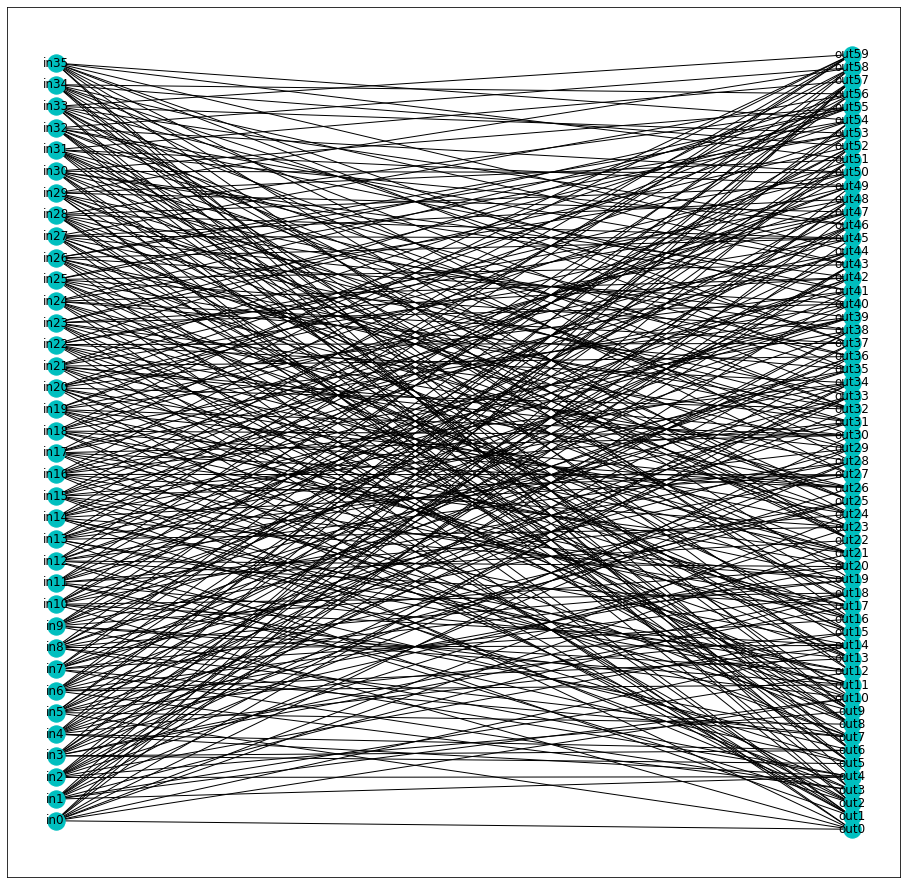

In [17]:
plt.figure(figsize=(16, 16))
print_layer_graph(layer_list[16].lut_list[1])